In [ ]:
# Download the file from Google Drive
!gdown --id 1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn
From (redirected): https://drive.google.com/uc?id=1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn&confirm=t&uuid=06605bf0-0750-4efc-a614-23e4cdd1615b
To: /content/workspace_updated.zip
100% 297M/297M [00:03<00:00, 78.6MB/s]


In [ ]:
!unzip /content/workspace_updated.zip

Archive:  /content/workspace_updated.zip
   creating: workspace/
  inflating: workspace/train_idx.npy  
  inflating: workspace/X_emb.npy     
  inflating: workspace/users_train.parquet  
  inflating: workspace/users.parquet  
  inflating: workspace/X_all.npy     
  inflating: workspace/test_idx.npy  
  inflating: workspace/users_test.parquet  
  inflating: workspace/X_all_train.npy  
  inflating: workspace/X_all_test.npy  


Workspace: /content/workspace
Shapes:
  X_all      : (206207, 132)
  users      : (206207, 1)
  train_idx  : (164965,)
  test_idx   : (41242,)

Scaling full feature matrix ...
Scaled shapes:
  X_train: (164965, 132)
  X_test : (41242, 132)

UMAP: fitting on TRAIN SAMPLE of size 50000 (out of 164965)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Transforming TRAIN / TEST / ALL with UMAP ...
UMAP shapes:
  X_train_umap: (164965, 10)
  X_test_umap : (41242, 10)
  X_all_umap  : (206207, 10)

HDBSCAN: fitting on TRAIN SAMPLE UMAP of size 50000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Cluster counts (ALL USERS):
-1       129
 0     22734
 1    113159
 2      1447
 3      4237
 4     64501
Name: count, dtype: int64


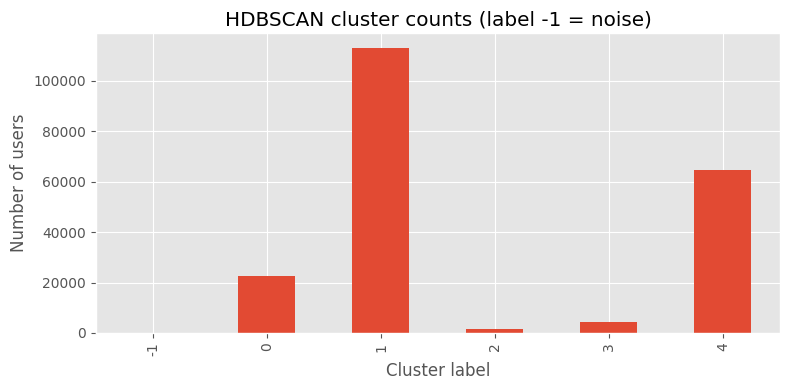


=== Internal metrics (UMAP space) ===
TRAIN      | Silhouette=0.6016 | Davies–Bouldin=0.4536
TEST       | Silhouette=0.6034 | Davies–Bouldin=0.4576

Metrics summary:


,split,silhouette,davies_bouldin
0,TRAIN,0.601583,0.453591
1,TEST,0.603357,0.457584



✅ Saved TEST HDBSCAN clusters to: /content/workspace/hdbscan_clusters_test.parquet
   Saved TEST membership strengths to: /content/workspace/hdbscan_probs_test.npy

✅ Saved ALL-USERS HDBSCAN clusters to: /content/workspace/hdbscan_clusters_all.parquet
   Saved ALL-USERS membership strengths to: /content/workspace/hdbscan_probs_all.npy


In [ ]:
# ======================================================================
# 03_umap_hdbscan_segments.ipynb
# Author: Akash
#
# Phase 3: UMAP + HDBSCAN Clustering (density-based)
#
# What this notebook does:
#   1. Loads common Phase 3 workspace data:
#       - X_all.npy          (embeddings + behaviour)
#       - users.parquet      (user_id per row)
#       - train_idx.npy / test_idx.npy  (global split)
#   2. Scales the features.
#   3. Runs UMAP on a TRAIN SAMPLE (for speed) and transforms:
#       - full TRAIN
#       - TEST
#       - ALL users
#   4. Fits HDBSCAN on the UMAP(train_sample) embedding.
#   5. Uses approximate_predict() to get labels for:
#       - TRAIN
#       - TEST
#       - ALL users
#   6. Computes Silhouette + Davies–Bouldin (ignoring noise -1).
#   7. Saves:
#       - hdbscan_clusters_test.parquet  (only test users)
#       - hdbscan_clusters_all.parquet   (all users)
#
# This mirrors the structure of the KMeans notebook but uses
# UMAP + HDBSCAN for flexible, density-based clusters.
# ======================================================================

import numpy as np
import pandas as pd
from pathlib import Path

import umap
import hdbscan
from hdbscan import approximate_predict

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

import matplotlib.pyplot as plt

plt.style.use("ggplot")

# -------------------- CONFIG ------------------------------------------
WORKSPACE_DIR = Path("/content/workspace")  # adjust if needed

RANDOM_STATE = 42
MAX_UMAP_FIT_SAMPLES = 50_000   # limit to avoid super slow UMAP/HDBSCAN on huge data
N_NEIGHBORS = 30
N_COMPONENTS = 10
MIN_CLUSTER_SIZE = 100
MIN_SAMPLES = 10

np.random.seed(RANDOM_STATE)

print("Workspace:", WORKSPACE_DIR)

# -------------------- LOAD DATA ---------------------------------------
X_all = np.load(WORKSPACE_DIR / "X_all.npy")           # (n_users, n_features)
users = pd.read_parquet(WORKSPACE_DIR / "users.parquet")

train_idx = np.load(WORKSPACE_DIR / "train_idx.npy")
test_idx  = np.load(WORKSPACE_DIR / "test_idx.npy")

print("Shapes:")
print("  X_all      :", X_all.shape)
print("  users      :", users.shape)
print("  train_idx  :", train_idx.shape)
print("  test_idx   :", test_idx.shape)

n_users = X_all.shape[0]
assert n_users == len(users), "X_all and users row count must match!"

# -------------------- SCALE FEATURES ----------------------------------
print("\nScaling full feature matrix ...")
scaler = StandardScaler().fit(X_all)
X_all_scaled = scaler.transform(X_all)

X_train = X_all_scaled[train_idx]
X_test  = X_all_scaled[test_idx]

users_train = users.iloc[train_idx].reset_index(drop=True)
users_test  = users.iloc[test_idx].reset_index(drop=True)

print("Scaled shapes:")
print("  X_train:", X_train.shape)
print("  X_test :", X_test.shape)

# -------------------- UMAP (fit on TRAIN SAMPLE for speed) ------------
n_train = X_train.shape[0]
rng = np.random.RandomState(RANDOM_STATE)

if n_train > MAX_UMAP_FIT_SAMPLES:
    fit_idx = rng.choice(n_train, size=MAX_UMAP_FIT_SAMPLES, replace=False)
    X_umap_fit = X_train[fit_idx]
    print(f"\nUMAP: fitting on TRAIN SAMPLE of size {X_umap_fit.shape[0]} (out of {n_train})")
else:
    fit_idx = None
    X_umap_fit = X_train
    print(f"\nUMAP: fitting on FULL TRAIN of size {X_umap_fit.shape[0]}")

umap_model = umap.UMAP(
    n_neighbors=N_NEIGHBORS,
    min_dist=0.1,
    n_components=N_COMPONENTS,
    random_state=RANDOM_STATE,
)
umap_model = umap_model.fit(X_umap_fit)

print("Transforming TRAIN / TEST / ALL with UMAP ...")
X_train_umap = umap_model.transform(X_train)
X_test_umap  = umap_model.transform(X_test)
X_all_umap   = umap_model.transform(X_all_scaled)

print("UMAP shapes:")
print("  X_train_umap:", X_train_umap.shape)
print("  X_test_umap :", X_test_umap.shape)
print("  X_all_umap  :", X_all_umap.shape)

# -------------------- HDBSCAN (fit on UMAP(train_sample)) -------------
if fit_idx is not None:
    X_hdb_fit = X_train_umap[fit_idx]
    print(f"\nHDBSCAN: fitting on TRAIN SAMPLE UMAP of size {X_hdb_fit.shape[0]}")
else:
    X_hdb_fit = X_train_umap
    print(f"\nHDBSCAN: fitting on FULL TRAIN UMAP of size {X_hdb_fit.shape[0]}")

hdb = hdbscan.HDBSCAN(
    min_cluster_size=MIN_CLUSTER_SIZE,
    min_samples=MIN_SAMPLES,
    cluster_selection_epsilon=0.0,
    prediction_data=True,   # required for approximate_predict
)

hdb.fit(X_hdb_fit)

# approximate_predict gives labels/probabilities for any points in same space
labels_train, strengths_train = approximate_predict(hdb, X_train_umap)
labels_test, strengths_test   = approximate_predict(hdb, X_test_umap)
labels_all, strengths_all     = approximate_predict(hdb, X_all_umap)

print("\nCluster counts (ALL USERS):")
cluster_counts_all = pd.Series(labels_all).value_counts().sort_index()
print(cluster_counts_all)

plt.figure(figsize=(8,4))
cluster_counts_all.plot(kind="bar")
plt.title("HDBSCAN cluster counts (label -1 = noise)")
plt.xlabel("Cluster label")
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()

# -------------------- METRICS -----------------------------------------
def cluster_metrics(X, labels, name=""):
    """Compute Silhouette & Davies–Bouldin, ignoring noise (-1)."""
    labels = np.asarray(labels)
    mask = labels != -1
    if mask.sum() < 2 or len(np.unique(labels[mask])) < 2:
        print(f"{name}: Not enough non-noise clusters for metrics.")
        return np.nan, np.nan
    sil = silhouette_score(X[mask], labels[mask])
    db  = davies_bouldin_score(X[mask], labels[mask])
    print(f"{name:10s} | Silhouette={sil:.4f} | Davies–Bouldin={db:.4f}")
    return sil, db

print("\n=== Internal metrics (UMAP space) ===")
sil_train, db_train = cluster_metrics(X_train_umap, labels_train, "TRAIN")
sil_test,  db_test  = cluster_metrics(X_test_umap,  labels_test,  "TEST")

metrics_df = pd.DataFrame(
    [
        {"split": "TRAIN", "silhouette": sil_train, "davies_bouldin": db_train},
        {"split": "TEST",  "silhouette": sil_test,  "davies_bouldin": db_test},
    ]
)
print("\nMetrics summary:")
display(metrics_df)

# -------------------- SAVE TEST CLUSTERS ------------------------------
users_test = users_test.copy()
users_test["hdbscan_cluster"] = labels_test

output_test = WORKSPACE_DIR / "hdbscan_clusters_test.parquet"
users_test.to_parquet(output_test, index=False)

np.save(WORKSPACE_DIR / "hdbscan_probs_test.npy", strengths_test)

print(f"\n✅ Saved TEST HDBSCAN clusters to: {output_test}")
print(f"   Saved TEST membership strengths to: {WORKSPACE_DIR / 'hdbscan_probs_test.npy'}")

# -------------------- SAVE ALL-USERS CLUSTERS -------------------------
users_all = users.copy()
users_all["hdbscan_cluster"] = labels_all

output_all = WORKSPACE_DIR / "hdbscan_clusters_all.parquet"
users_all.to_parquet(output_all, index=False)

np.save(WORKSPACE_DIR / "hdbscan_probs_all.npy", strengths_all)

print(f"\n✅ Saved ALL-USERS HDBSCAN clusters to: {output_all}")
print(f"   Saved ALL-USERS membership strengths to: {WORKSPACE_DIR / 'hdbscan_probs_all.npy'}")
